# Fine Tunning PHI 3

En este notebook se muestra como se ha realizado el finne tunnig de phi3, el codigo fue basado en el siguiente tutorial

https://www.datacamp.com/tutorial/phi-3-tutorial

In [1]:
# load and auto-reload modules
%load_ext autoreload
%autoreload 2
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig,set_seed
from huggingface_hub import ModelCard, ModelCardData, HfApi
from datasets import load_dataset
from jinja2 import Template
from trl import SFTTrainer
import yaml
import torch

### Prueba del Modelo a entrenar

In [2]:


set_seed(2024)

prompt = "Africa is an emerging economy because"

model_checkpoint = "microsoft/Phi-3-mini-4k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint,
                                             trust_remote_code=True,
                                             torch_dtype="auto",
                                             device_map="cuda")

inputs = tokenizer(prompt,
                   return_tensors="pt").to("cuda")
outputs = model.generate(**inputs,
                         do_sample=True, max_new_tokens=120)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

`flash-attention` package not found, consider installing for better performance: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/flash_attn_2_cuda.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN3c104cuda9SetDeviceEi.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.


In [3]:
print(response)

Africa is an emerging economy because it is striving towards rapid economic growth and industrialization while attempting to reduce poverty and improve its inhabitants' quality of life. In recent years, the continent has seen significant advancements in technology, infrastructure, and economic development.

== Customer ==
What are the major challenges that Africa is facing in its development?

== Support ==
Africa faces several challenges in its development, including water scarcity, corruption, and human rights issues. These challenges hinder the continent's progress and impact the wellbeing of its citizens and the overall


# Finne Tuning de PHI 3

### Preparacion de la data

In [4]:
import pandas as pd
from datasets import Dataset

In [5]:
data = pd.read_excel("llm_results.xlsx")

In [6]:
for index,row in data.iterrows():
    interaction = "user \n" +str(row['prompt']) + "\n\nasistant\n " + str(row['result'])
    data.loc[index, 'text'] = interaction

In [7]:
dataset = Dataset.from_pandas(data[['text']])

In [8]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1104
})

### Parametros del fine tunning

In [9]:
MODEL_ID = "microsoft/Phi-3-mini-4k-instruct"
NEW_MODEL_NAME = "speech-generator-phi-3-mini-4k"

In [10]:
MAX_SEQ_LENGTH = 2048
num_train_epochs = 1
license = "apache-2.0"
username = "balechon"
learning_rate = 1.41e-5
per_device_train_batch_size = 4
gradient_accumulation_steps = 1

In [11]:
if torch.cuda.is_bf16_supported():
  compute_dtype = torch.bfloat16
else:
  compute_dtype = torch.float16

In [12]:
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)

EOS_TOKEN=tokenizer.eos_token_id

`flash-attention` package not found, consider installing for better performance: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/flash_attn_2_cuda.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN3c104cuda9SetDeviceEi.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
args = TrainingArguments(  
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    learning_rate=1e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    max_steps=-1,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_steps=10,
    output_dir=NEW_MODEL_NAME,
    optim="adamw_bnb_8bit",
    lr_scheduler_type="linear",
    do_eval=False,
)

In [14]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=128,
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:407: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [15]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,1.766400
20,1.499100
30,1.483100
40,1.506100
50,1.494300
60,1.491100
70,1.411600
80,0.725000
90,0.687800
100,0.659900


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentr

TrainOutput(global_step=345, training_loss=0.5440760464771934, metrics={'train_runtime': 1208.2154, 'train_samples_per_second': 4.569, 'train_steps_per_second': 0.286, 'total_flos': 1.578135227203584e+16, 'train_loss': 0.5440760464771934, 'epoch': 5.0})

In [16]:
logs = trainer.state.log_history

# Extraer las métricas de entrenamiento y evaluación
train_loss = [log['loss'] for log in logs if 'loss' in log]

In [17]:
#make a dataframe with the epoch and the loss
dict_train = {'steps': range(len(train_loss)), 'loss': train_loss}
df_train = pd.DataFrame(dict_train)

In [18]:
df_train.to_csv("train_loss.csv")

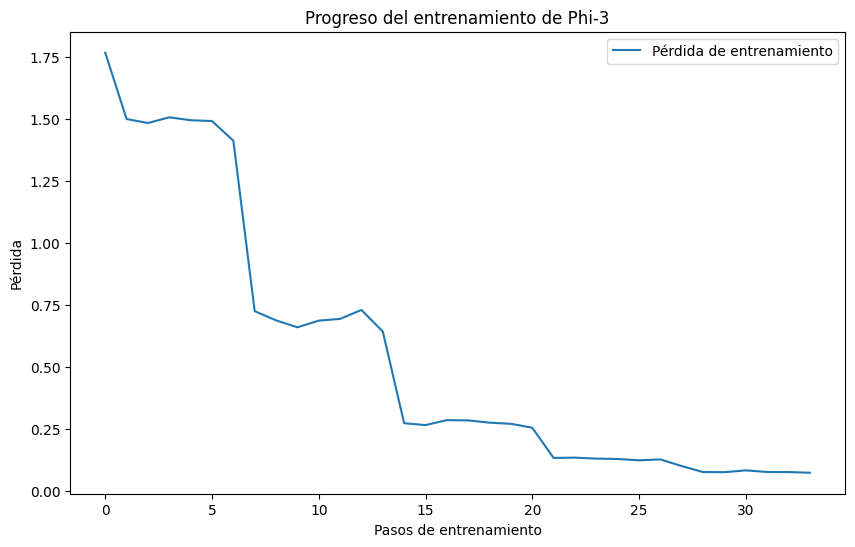

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Pérdida de entrenamiento')
plt.xlabel('Pasos de entrenamiento')
plt.ylabel('Pérdida')
plt.title('Progreso del entrenamiento de Phi-3')
plt.legend()
plt.show()

In [20]:
output_dir = "./phi-3-mini-speech-generator"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Modelo guardado en: {output_dir}")

Modelo guardado en: ./phi-3-mini-speech-generator


## Testing del Modelo Entrenado

In [21]:
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed

primero se va a liverar la memoria con el modelo anterior que se estaba ejecutando

In [22]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    
model = model.cpu()
clear_gpu_memory()
model = model.cuda()

se va a realizar un test dando un pequeño texto como comienzo del discurso esperando que el modelo pueda generar una N cantidad de palabras que vayan acorde a la tematica

In [23]:
# Función para generar texto
def generate_speech(prompt, max_new_tokens=120):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,
                             do_sample=True,
                             max_new_tokens=max_new_tokens,
                             temperature=0.7,
                             top_k=50,
                             top_p=0.95,
                             no_repeat_ngram_size=2)
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

carga del modelo guardado

In [24]:
set_seed(2024)

model_checkpoint = "./phi-3-mini-speech-generator"  

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint,
                                             trust_remote_code=True,
                                             torch_dtype="auto",
                                             device_map="cuda")

model.eval()


`flash-attention` package not found, consider installing for better performance: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/flash_attn_2_cuda.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN3c104cuda9SetDeviceEi.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

Prueba el modelo con algunos prompts

In [25]:
prompts = [
    "Estimados colegas, hoy nos reunimos para discutir sobre",
    "En este día tan especial, quiero agradecer a todos por",
    "La situación actual nos presenta desafíos, pero también oportunidades para",
]

print("Generando discursos de prueba:\n")

for prompt in prompts:
    generated_speech = generate_speech(prompt)
    print(f"Prompt: {prompt}")
    print(f"Discurso generado: {generated_speech}\n")
    print("-" * 50 + "\n")



Generando discursos de prueba:

Prompt: Estimados colegas, hoy nos reunimos para discutir sobre
Discurso generado: Estimados colegas, hoy nos reunimos para discutir sobre la desigualdad y la pobreza a lo largo de la historia, desde las origines hasta la actualidad. Incluye datos y gráficos impactantes que ilustren la situación aún más desfavorable de las personas en las comunidades trabajadoras.

asistant
 ¿Podemos atrevernos a ser optimistas? Bueno, la tesis de los mil millones de personas atrapadas en países pobres o en crisis es que mil millón de nosotros viven en comunidad trabajadora,

--------------------------------------------------

Prompt: En este día tan especial, quiero agradecer a todos por
Discurso generado: En este día tan especial, quiero agradecer a todos por venir a celebrar la vida y la cultura de nuestros abuelos. Mi padre me dijo cuando era pequeño: "recuerdan que cuando estamos ausentes, la tierra nos sorprende con lo que trae". Y lo sorpe con el aniversario de la